In [1]:
import os
import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
classify_train_dir = str(input("Classify Train Dir: "))
classify_train = os.path.join(classify_train_dir, 'classify train')

    
TRAINING_DIR = os.path.join(classify_train, 'training')
VALIDATION_DIR = os.path.join(classify_train, 'validation')
TESTING_DIR = os.path.join(classify_train, 'testing')

Classify Train Dir: /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/cov-cxr


In [5]:
TRAINING_DIR, VALIDATION_DIR, TESTING_DIR

('/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/cov-cxr/classify train/training',
 '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/cov-cxr/classify train/validation',
 '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/cov-cxr/classify train/testing')

In [6]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))

Enter the initial learning rate: 0.001
Enter the maximum number of epochs: 100
Enter batch size: 8


In [7]:
char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(classify_train_dir, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char)
        os.mkdir(char)
    elif replace.upper() == 'N':
        pass

Enter name of the characteristics folder: xception


In [8]:
def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))
    
best_model_address = os.path.join(char, 'best_model.h5')

In [9]:
monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


if monitor == 1:
    metric = 'val_accuracy'
    mode = 'max'
    print("\nMONITORING VALIDATION ACCURACY..........\n")

elif monitor == 2:
    metric = 'val_loss'
    mode = 'min'
    print("\nMONITORING VALIDATION LOSS..........\n")

elif monitor == 3:
    metric = 'accuracy'
    mode = 'max'
    print("\nMONITORING TRAINING ACCURACY..........\n")

elif monitor == 4:
    metric = 'loss'
    mode = 'min'
    print("\nMONITORING TRAINING LOSS..........\n")

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode , period=1)]

print("\nTraining will stop if Validation Accuracy doesn't show any improvements for " + str(patience) + " epcohs\n")

Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4
Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: 10

MONITORING TRAINING LOSS..........


Training will stop if Validation Accuracy doesn't show any improvements for 10 epcohs



In [10]:
def Xception():
    print("\nTRAINING ON Xception MODEL:-")

    base_model = keras.applications.Xception(input_shape = dim, weights = 'imagenet', include_top = False)

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(dense)(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)

    predictions = Dense(output_layer, activation = output_activation)(x)

    model = Model(inputs = base_model.input, outputs=predictions)

    train_base_model = str(input("Do you want to train the base model of Xception?(Y/N) "))
    if train_base_model.upper() == 'Y':
        for layer in base_model.layers:
            layer.trainable = True
    elif train_base_model.upper() == 'N':
        for layer in base_model.layers:
            layer.trainable = False

    return model

In [11]:
class_no = len(os.listdir(TRAINING_DIR))

if class_no > 2:
    print("This is a " + str(class_no) + "-Class Classification")
    output_activation = 'softmax'
    losses = 'categorical_crossentropy'
    class_mode = 'categorical'
    output_layer = class_no
else:
    print("This is a Binary Classification")
    output_activation = 'sigmoid'
    losses = 'binary_crossentropy'
    class_mode = 'binary'
    output_layer = 1

This is a 3-Class Classification


In [12]:
def optimizer_selection():
    print("\nSelect a optimizer which will reduce the loss of the model.\n")

    optimizer_select = int(input("Press 1 to select Stochastic Gradient Descent\nPress 2 to select RMSprop\nPress 3 to select Adagrad\nPress 4 to select Adadelta\nPress 5 to select Adam\nPress 6 to select Adamax\nPress 7 to select Nadam\n"))

    if optimizer_select == 1:
        optimizer = SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

    elif optimizer_select == 2:
        optimizer = RMSprop(learning_rate, rho = 0.9)

    elif optimizer_select == 3:
        optimizer = Adagrad(learning_rate)

    elif optimizer_select == 4:
        optimizer = Adadelta(learning_rate, rho = 0.95)

    elif optimizer_select == 5:
        optimizer = Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    elif optimizer_select == 6:
        optimizer = Adamax(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)

    elif optimizer_select == 7:
        optimizer = Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
   
    return optimizer

In [13]:
h = int(input("Image Dimension(H or W): "))
w = h
dim = [h,w,3]

Image Dimension(H or W): 128


In [14]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    target_size = (h,w),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              target_size = (h,w),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  target_size = (h,w),
                                                  shuffle=True)

Found 8591 images belonging to 3 classes.
Found 399 images belonging to 3 classes.
Found 1995 images belonging to 3 classes.


In [15]:
dense = int(input("Enter the no. of neurons in dense layer: "))
dropout = float(input("Enter the dropout percentage: "))
dropout = dropout/100

optimizer = optimizer_selection()

Enter the no. of neurons in dense layer: 128
Enter the dropout percentage: 20

Select a optimizer which will reduce the loss of the model.

Press 1 to select Stochastic Gradient Descent
Press 2 to select RMSprop
Press 3 to select Adagrad
Press 4 to select Adadelta
Press 5 to select Adam
Press 6 to select Adamax
Press 7 to select Nadam
5


In [17]:
model= Xception()
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()


TRAINING ON Xception MODEL:-
83689472/83683744 [==============================] - 12s 0us/step
Do you want to train the base model of Xception?(Y/N) y
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63

In [18]:
with tf.device('/GPU:0'):
    start = time.time()
    history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle=True)

    end = time.time()
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
1074/1074 [==============================] - 73s 61ms/step - loss: 0.4705 - accuracy: 0.8346 - precision: 0.8460 - recall: 0.8187 - true_positives: 3677.4158 - true_negatives: 8088.7060 - false_positives: 518.3767 - false_negatives: 626.1256 - val_loss: 0.0654 - val_accuracy: 0.9774 - val_precision: 0.9799 - val_recall: 0.9774 - val_true_positives: 390.0000 - val_true_negatives: 790.0000 - val_false_positives: 8.0000 - val_false_negatives: 9.0000

Epoch 00001: loss improved from inf to 0.31867, saving model to /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/cov-cxr/xception/best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
1074/1074 [==============================] - 64s 60ms/step - loss: 0.1447 - accuracy: 0.9561 - precision: 0.9592 - recall: 0.9556 - true_positives: 4109.9609 - true_negatives: 8429.6214 - false_positives: 178.3302 - false_negatives

Epoch 13/100

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0001.
1074/1074 [==============================] - 62s 58ms/step - loss: 0.0085 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - true_positives: 4298.1014 - true_negatives: 8601.1786 - false_positives: 4.9758 - false_negatives: 4.9758 - val_loss: 0.0198 - val_accuracy: 0.9925 - val_precision: 0.9925 - val_recall: 0.9925 - val_true_positives: 396.0000 - val_true_negatives: 795.0000 - val_false_positives: 3.0000 - val_false_negatives: 3.0000

Epoch 00013: loss did not improve from 0.00541
Epoch 14/100

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0001.
1074/1074 [==============================] - 62s 57ms/step - loss: 0.0018 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - true_positives: 4302.9795 - true_negatives: 8606.6995 - false_positives: 0.5172 - false_negatives: 0.6288 - val_loss: 0.0184 - val_accuracy: 0.9925 - val_precision: 0.9925 - val_recall: 0.9925 - val_true_pos

250/250 [==============================] - 5s 20ms/step - loss: 0.1084 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9689 - true_positives: 1933.0000 - true_negatives: 3931.0000 - false_positives: 59.0000 - false_negatives: 62.0000


In [19]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 1661.0059010982513 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


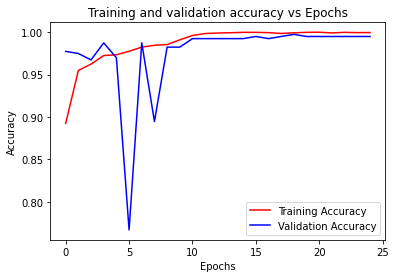

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


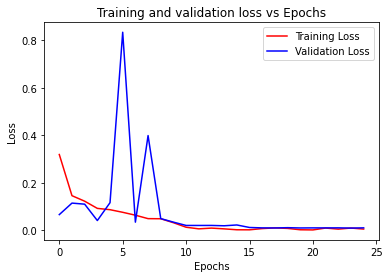

In [20]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()
accuracy_fig_name = "accuracy.eps"
plt.savefig(os.path.join(char, accuracy_fig_name))
plt.show()


plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()
loss_fig_name = "loss.eps"

plt.savefig(os.path.join(char, loss_fig_name))
plt.show()

In [21]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 100.0 %
The validation accuracy is: 99.24812316894531 %
The test accuracy is: 97.0426082611084 %


In [22]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [23]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

Test Accuracy: 97.0426082611084
Test Precision: 97.0381498336792
Test Recall: 96.89223170280457
True Positive: 1933
Test Negetive: 3931
False Positive: 59
False Negetive: 62
Sensitivity: 96.89223057644111
Specificity: 98.52130325814537


In [24]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print("Please read the text file named " + readme_name_text + " for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if len(os.listdir(TRAINING_DIR)) > 2:
    readme.write("This is a MULTICLASS CLASSIFICATION")
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write("\nInitial Learning Rate = " + str(learning_rate))
readme.write("\nNo. of epochs = " + str(len(acc)))
readme.write("\nBatch Size = " + str(batch_size))


readme.write("\n\n--MODEL-PARAMETERS--")
readme.write("\nActivation Function = relu")
readme.write("\nDropout = " + str(int(dropout*100)) + "%")
readme.write("\nActivation function of the output layer = " + str(output_activation))
readme.write("\nCost function of the model = " + str(losses))
readme.write("\nOptimizer = " + str(optimizer) + "\n\n")


readme.write("Trained on a Resnet50 Model\n")
with redirect_stdout(readme):
    model.summary()
        
    
readme.write("\n\n--MODEL-PERFORMANCE--")
readme.write("\nTest Accuracy = " + str(test_accuracy) + " %")
readme.write("\nTest Precision = " + str(test_precision) + " %")
readme.write("\nTest Recall = " + str(test_recall) + " %")
readme.write("\nTrue Positive = " + str(tp))
readme.write("\nTrue Negetive = " + str(tn))
readme.write("\nFalse Positive = " + str(fp))
readme.write("\nFalse Negetive = " + str(fn))
readme.write("\nSensitivity = " + str(sensitivity))
readme.write("\nSpecificity = " + str(specificity) + " \n\n\n")


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write("\nacc = " + str(acc))
readme.write("\n\nval_acc = " + str(val_acc))
readme.write("\n\nloss = " + str(loss))
readme.write("\n\nval_loss = " + str(val_loss))


readme.write("\nExecution Time: {} seconds".format(duration))

readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
